# ECAL PhiSym on NanoAOD with awkward+coffea

## Import all the tools
    - use EcalPhiSymSchema to load the data into the proper classes

In [1]:
import os
import awkward as ak
import numpy as np
import pandas as pd
from coffea.nanoevents import NanoEventsFactory
from ecalphisym import EcalPhiSymSchema

In [2]:
import matplotlib.pyplot as plt
import mplhep
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.rcParams['xaxis.labellocation'] = 'right'
plt.rcParams['yaxis.labellocation'] = 'top'
plt.style.use(mplhep.style.ROOT)

In [3]:
# replace with proper test file location
runs = NanoEventsFactory.from_root('../Run2018D_test.root',
                                   schemaclass=EcalPhiSymSchema,
                                   treepath="/Runs").events()

In [4]:
#replace with the correct folder output location
outputPlot = "../MonitoringPlot"
outputICs = "../ICs"

folders = [outputPlot, outputICs]
for folder in folders:
    os.makedirs(folder, exist_ok=True)   

## Group data by fill number
    - Prepare the grouping 
    - Perform the grouping using awkward.unflatten separately on each main collection

In [5]:
counts = np.unique(runs.EcalPhiSymInfo.fill, return_index=True)[1]
splits = np.diff(np.concatenate([counts, [len(runs.EcalPhiSymInfo.fill)]]))

In [6]:
info = ak.unflatten(runs.EcalPhiSymInfo, splits, axis=0, behavior=runs.behavior).sum(axis=1)
ebhits = ak.unflatten(runs.EcalPhiSymEB, splits, axis=0, behavior=runs.behavior).sum(axis=1)
eehits = ak.unflatten(runs.EcalPhiSymEE, splits, axis=0, behavior=runs.behavior).sum(axis=1)

In [7]:
niovs = len(info.fill)

## Compute k-factors
    - keep same definition as in Run2: the miscalibration values are centered
    at 0.

In [8]:
k = ak.linear_fit(info.miscalibs_eb, ebhits.sumet_v, axis=2)

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(
C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


# K-factors plots examples
    - all k-factors (slopes from the fits)
    - all intercepts
    - 1 channel k-factor history
    - 1 iov k-factors map

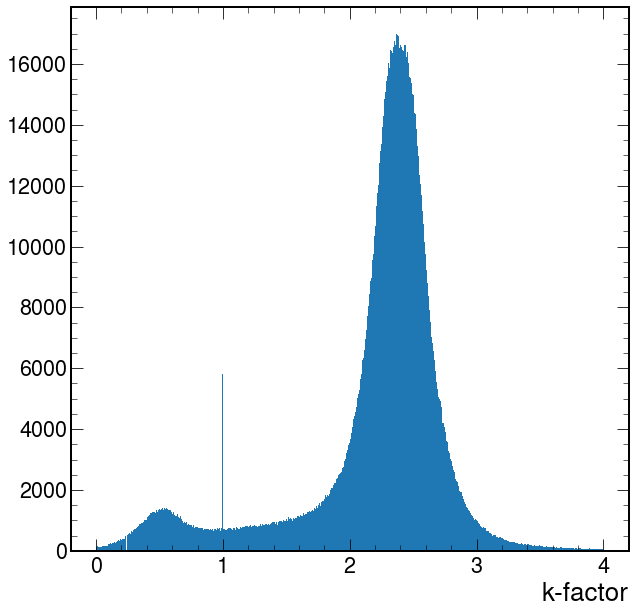

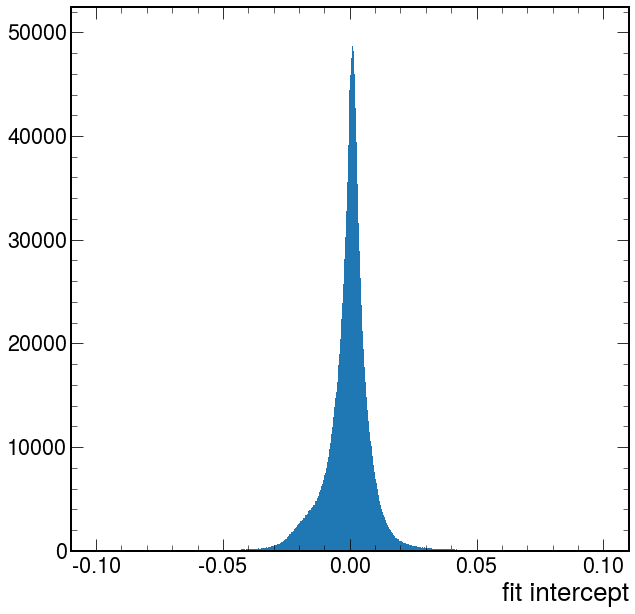

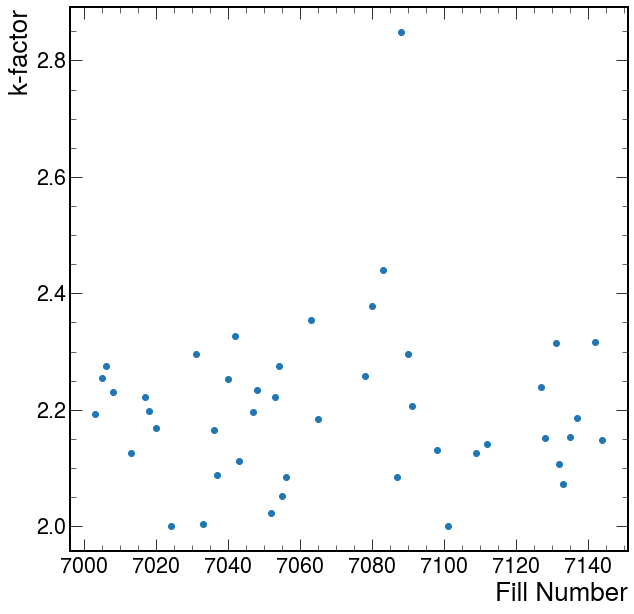

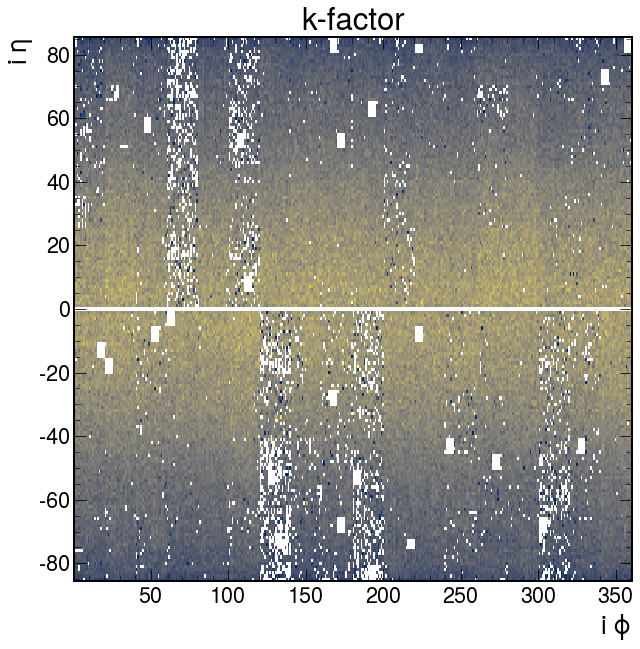

In [9]:
# k-factor histo
plt.hist(ak.flatten(k.slope), bins=1000, range=[0,4])
plt.xlabel('k-factor')
plt.show()

plt.hist(ak.flatten(k.intercept), bins=1000, range=[-0.1, 0.1])
plt.xlabel('fit intercept')
plt.show()

# k-factor vs fill
plt.scatter(info.fill, k.slope[:,100])
plt.xlabel('Fill Number')
plt.ylabel('k-factor')
plt.show()

# k-factor map
plt.hist2d(ak.to_numpy(ebhits.iphi[1,:]), ak.to_numpy(ebhits.ieta[1,:]), weights=ak.to_numpy(k.slope[1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='cividis', cmin=2, cmax=3)
plt.xlabel('i $\phi$')
plt.ylabel('i $\eta$')
plt.title('k-factor')
plt.show()

## Compute EFlow
    - remove boundary channels (SM and module boundaries) from the total EB sum
    - Note: double check this definition with the Run2 one
    - Note: there was an issue with the first fill in the test file used for this example, hence the analysis starts from iov 1
    
## To be implemented
    - The reweighting to match electrons eta distribution


In [10]:
def boundaryCrystals(data):
    """
    Flag crystals on module boundaries:
    - first and last crystals in a SM along phi (iphi % 20 == 0|1)
    - first and last crystals in a module along eta (|ieta| = 1, 25,26, 45,46, 65,66, 85)
    """

    bounds = ak.zeros_like(data.ieta)
    for idx in [1, 25, 25, 45, 46, 65, 66, 85]:
        bounds = bounds + (abs(data.ieta) == idx)
        
    return (data.iphi % 20 == 0) | (data.iphi % 20 == 1) | (bounds > 0)

In [11]:
sumEtEB = ak.sum(ak.mask(ebhits.sumet, boundaryCrystals(ebhits), valid_when=False), axis=1)

In [12]:
# Compute ICs normalized to first IOV
norm = ak.Array(np.repeat([ebhits.sumet[1]/sumEtEB[1]], niovs, axis=0)) 
eflow = (((ebhits.sumet/sumEtEB)/norm)-1)/k.slope+1

## Weights to match eta ele distribution

In [13]:
# to be implemented

## EFlow plots examples

In [14]:
# Enable Saving the plots
savePlots = True 
formats = ['.png','.pdf']

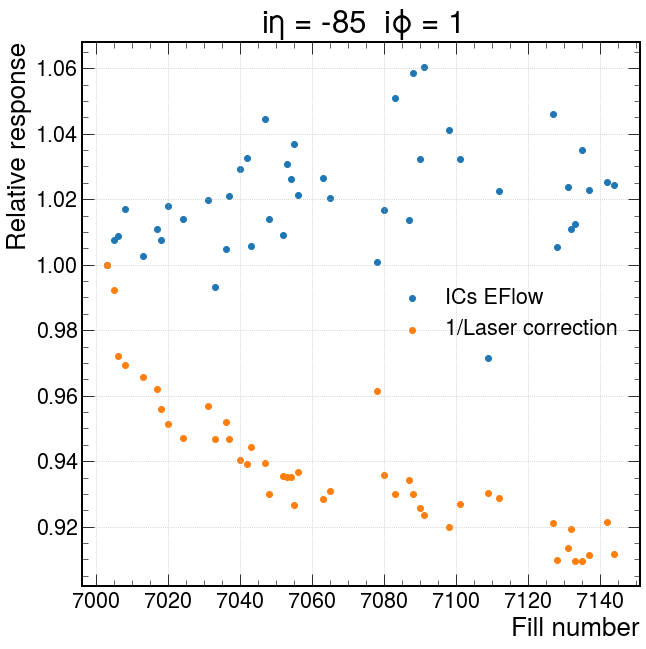

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


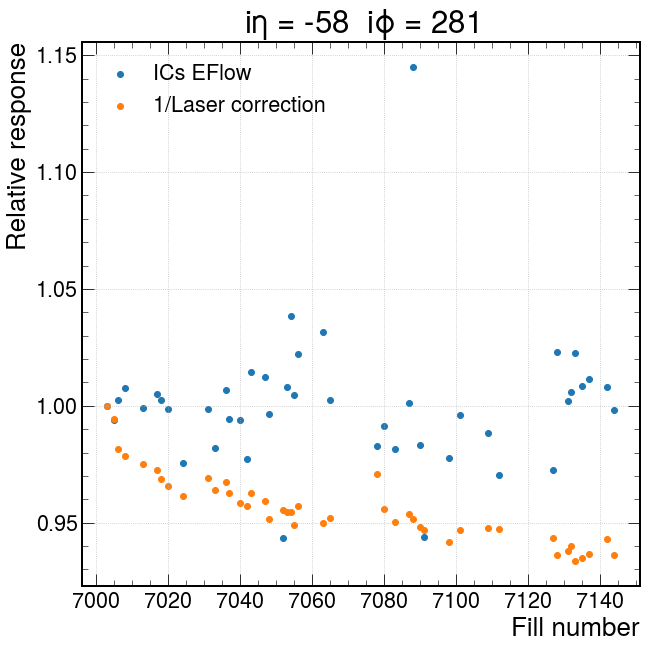

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


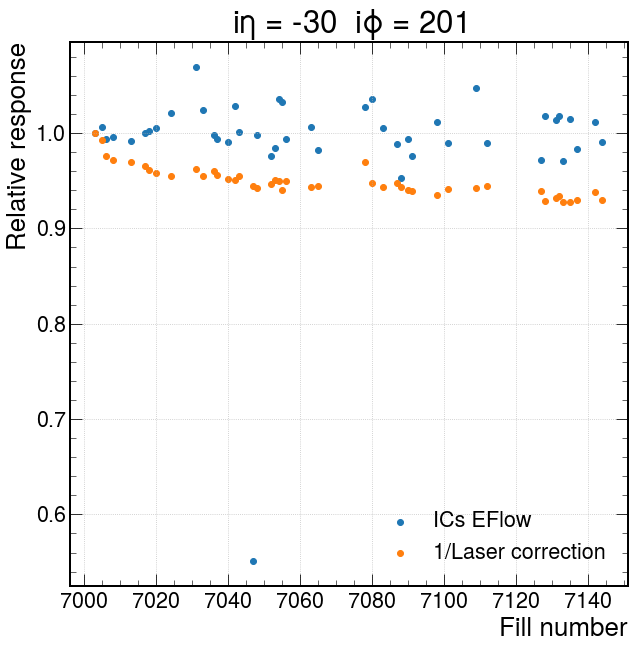

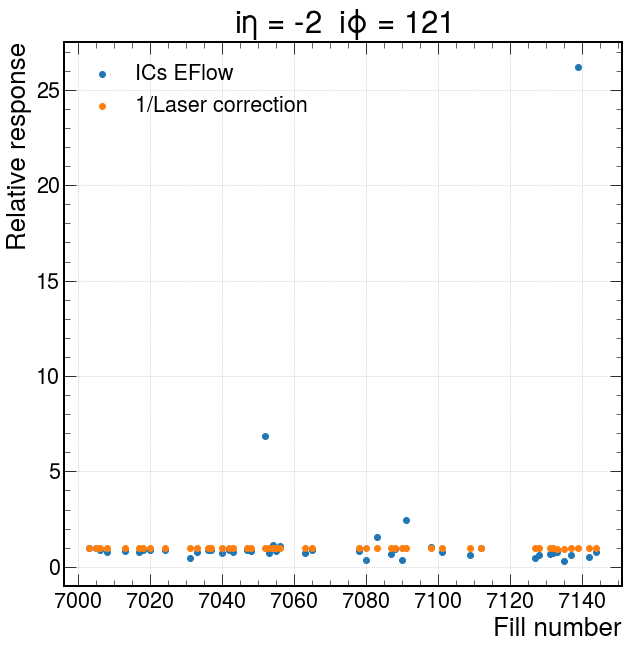

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


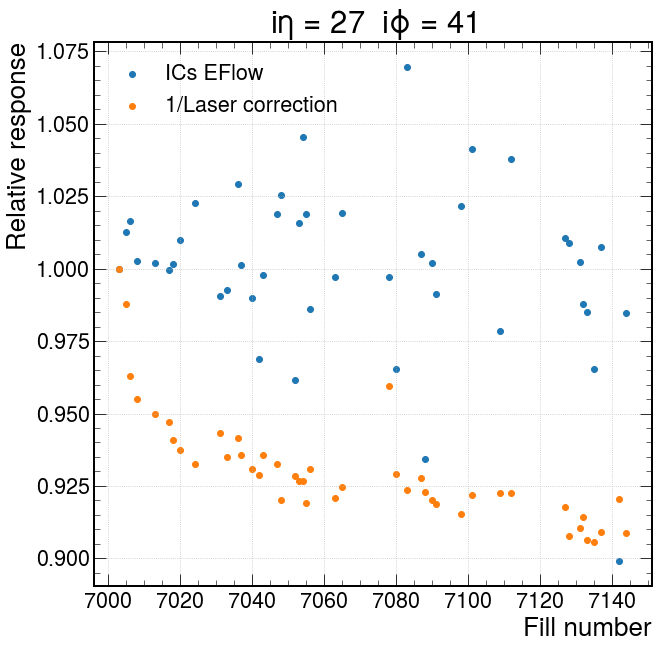

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


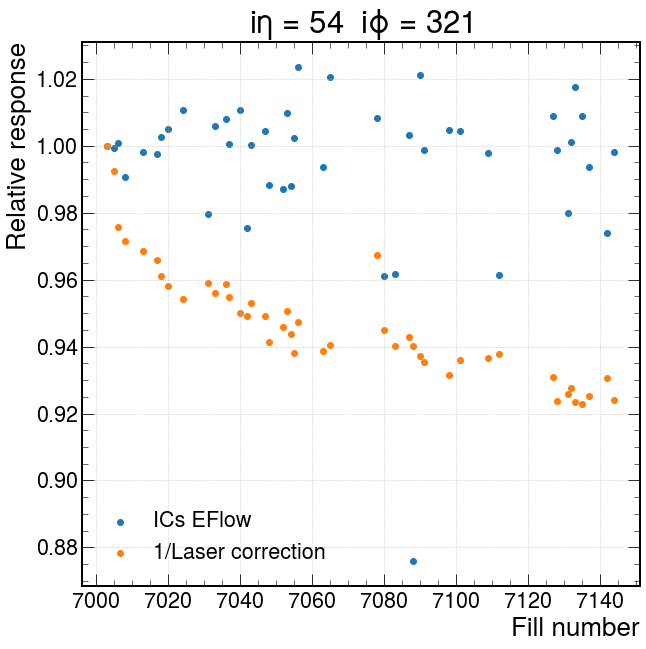

C:\Users\flavi\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


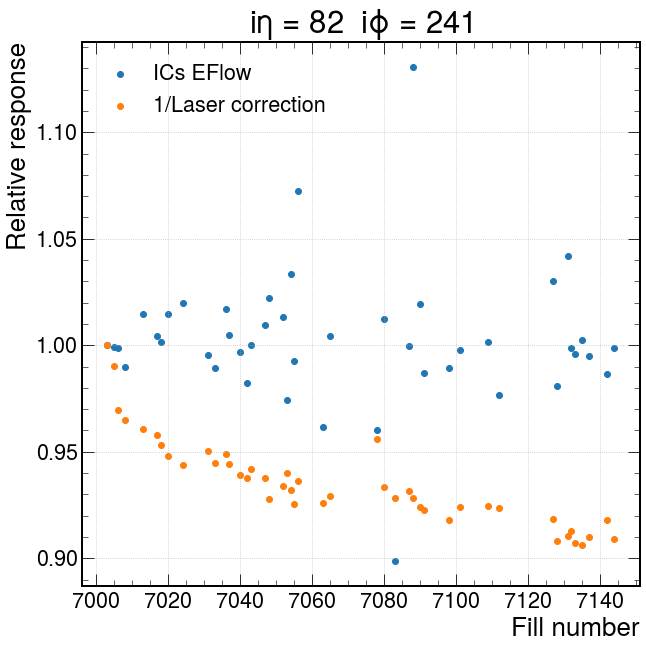

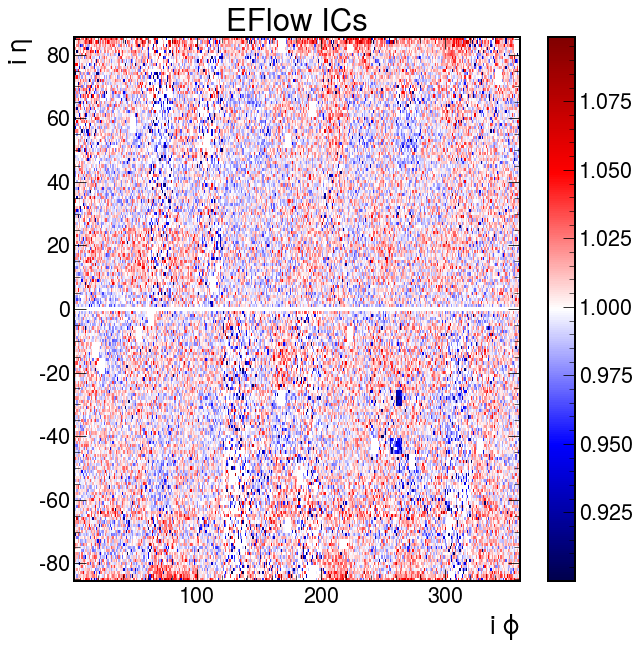

In [15]:
# plot of the laser corrections and eflow ics for some xstals
for ixstal in range(0,62100,10000):
    plt.scatter(info.fill[1:], eflow[1:,ixstal], label='ICs EFlow')
    plt.scatter(info.fill[1:], (ebhits.sumlc[1,ixstal]/ebhits.nhits[1,ixstal])/(ebhits.sumlc[1:,ixstal]/ebhits.nhits[1:,ixstal]), 
            label='1/Laser correction')
    plt.legend()
    plt.xlabel('Fill number')
    plt.ylabel('Relative response')
    plt.title("i$\eta$ = "+str(int(ebhits.ieta[1,ixstal]))+"  i$\phi$ = "+str(ebhits.iphi[1,ixstal]))
    plt.grid()
    if savePlots: 
        for form in formats:
            plt.savefig(outputPlot+'/monitoring_ieta'+str(int(ebhits.ieta[1,ixstal]))+'_iphi'+str(int(ebhits.iphi[1,ixstal]))+form)

    plt.show()

# plot the map of the last iov
plt.hist2d(ak.to_numpy(ebhits.iphi[-1,:]), ak.to_numpy(ebhits.ieta[-1,:]), weights=ak.to_numpy(eflow[-1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='seismic', cmin=0.9, cmax=1.1)
plt.xlabel('i $\phi$')
plt.ylabel('i $\eta$')
plt.title('EFlow ICs')

plt.colorbar()
if savePlots: 
    fillnum = str(info.fill[-1]).replace("[","").replace("]","")
    for form in formats:
        plt.savefig(outputPlot+'/mapICs_fill'+fillnum+form)
plt.show()




### ICs saved in the correct format

In [16]:
# FORMAT: ieta - iphi - zside - eflow - error NB now error is 0
# One folder is created for each IOV
# Passing trough PD
saveICs = True
if saveICs:
    for ifill in range(1,len(info.fill)):
        tosave = pd.concat ([ak.to_pandas(ebhits[ifill].ieta), ak.to_pandas(ebhits[ifill].iphi), ak.to_pandas(ebhits[ifill].zside()), ak.to_pandas(eflow[ifill])], axis = 1)
        tosave[''] = 0 
        os.makedirs(outputICs+"/"+str(info.fill[ifill]).replace("[","").replace("]",""), exist_ok=True)   
        tosave.to_csv(outputICs+"/"+str(info.fill[ifill]).replace("[","").replace("]","")+"/file.txt", " ", index=False, header=False)
        
